In [1]:
using Images, LinearAlgebra

### Using a SVD to compress an image

In this exercise, we'll use a singular value decomposition (SVD) to compress an image -- so that we can store an image without keeping around "unnecessary" information.

To start, let's define a singular value decomposition. In a SVD, we take a matrix $A$ and factorize it so that

$$A = USV^T$$

where matrices $U$ and $V$ are unitary and hold our singular vectors. Matrix $S$ is diagonal and stores our singular values in decreasing order from top/left to bottom/right.

In Julia, our images are stored as arrays, so we can think of `yellowbanana` as a matrix

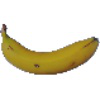

In [2]:
yellowbanana = load("images/104_100.jpg")

In [3]:
size(yellowbanana)

(100, 100)

In [4]:
yellowbanana[60,50] # Each element in the array is a color

That means we can take the SVD of this image. So, we can store this picture of a banana as sets of singular vectors and singular values.

**The reason this is important** is that we'll find that we do **not** need to keep track of *all* the singular vectors and *all* the singular values to store an image that still looks like a banana! This means we can choose to keep only the important information, throw away the rest, and thereby "compress" the image.

Working with grayscale images is a bit easier, so let's work with the gray version of this banana.

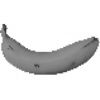

In [5]:
banana = Gray.(yellowbanana)

Note that `banana` is a (100 x 100) matrix that stores a pixel -- information about the color -- at each entry.

In [6]:
size(banana)

(100, 100)

If we take the `channelview` of `banana`, we'll see the numbers that describe the color at each point in the array:

In [7]:
channelview(banana)

100×100 reinterpret(N0f8, ::Array{Gray{N0f8},2}):
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0

Note that you can call `Gray` on the `channelview` of an image to display the image!

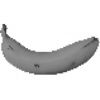

In [8]:
Gray.(channelview(banana))

**So how can we use a SVD to determine what information in an image is really important?**

The singular values tell us!

If we have matrices $U$, $S$, and $V$ from our image, we can rebuild that image with the matrix product $USV^T$. 

Taking this matrix product is the same as adding together the outer products of each corresponding pair of vectors from $U$ and $V$, scaled by a singular value ($\sigma$) from $S$. In other words, for a (100 x 100) pixel image,

$$A_{image} = USV^T = \sum_{i = 1}^{100} \sigma_i \mathbf{u_i}\mathbf{v_i'} $$

Every outer product $u_i * v_i'$ creates a (100 x 100) matrix. Here we're summing together one hundred (100 x 100) matrices in order to create the original matrix $A_{image}$. The matrices at the beginning of the series -- those that are scaled by **large** singular values -- will be **much** more important in recreating the original matrix $A_{image}$.

This means we can approximate $A_{image}$ as

$$A_{image} \approx \sum_{i = 1}^{n} \sigma_i \mathbf{u_i}\mathbf{v_i'}$$

where $n < 100$.

For example, if we rebuild our image of a banana using only 30 (instead of all 100) singular values, we get

<img src="images/banana_30svals.png" alt="Drawing" style="width: 100px;"/>

Using 10, 5, and then 3 singular values, we get

<img src="images/banana_10svals.png" alt="Drawing" style="width: 100px;"/>
<img src="images/banana_5svals.png" alt="Drawing" style="width: 100px;"/>
<img src="images/banana_3svals.png" alt="Drawing" style="width: 100px;"/>

#### Exercise

Write a function called `compress_image`. Its input arguments should be an image and the factor by which you want to compress the image. A compressed grayscale image should display when `compress_image` is called.

For example,

```julia
compress_image("images/104_100.jpg", 33)
```

will return a compressed image of a grayscale banana built using 3 singular values. (This image has 100 singular values, so use `fld(100, 33)` to determine how many singular values to keep. `fld` performs "floor" division.)

*Hints*: 

* Perform the SVD on the `channelview` of a grayscale image.
* In an empty input cell, execute `?svd` to find a function that wil perform an SVD for you.

In [9]:
function compress_image(image::Matrix{<:Gray}, d::Integer=3)
    X = map(float, image)
    F = svd(X)
    A = F.U[:, 1:d] * Diagonal(F.S[1:d]) * F.Vt[1:d,:]
    return map(Gray, A)
end

compress_image (generic function with 2 methods)

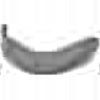

In [13]:
compress_image(banana,6)